In [5]:
%load_ext autoreload
%autoreload 2

import os
import re
import sys

sys.path.append(os.path.abspath("../"))


import faiss
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.llms import OpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 1000)
pd.set_option("display.max_rows", 400)


load_dotenv()


from src.data_utils import PodcastContainer, load_clean_scores
from src.player_utils import PlayerUtil
from src.utils import get_repo_root

scores = load_clean_scores(["2022-23", "2023-24"])
scores.head(5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,season_year,game_date,gameId,matchup,teamName,teamSlug,personId,personName,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed,outperform_next,fantasyDiff,injured
359494,2022-23,2022-10-18,22200001,PHI @ BOS,76ers,sixers,200782,pj tucker,33.016667,3,5,0.600,0,2,0.000,0,0,0.0,2,2,4,0,0,1,2,2,6,-6,12.00,17.15,0,1,-5.15,0
359495,2022-23,2022-10-18,22200001,BOS vs. PHI,celtics,celtics,201143,al horford,23.100000,2,7,0.286,2,5,0.400,0,0,0.0,1,4,5,1,0,0,0,4,6,8,13.75,35.15,0,0,-21.40,0
359496,2022-23,2022-10-18,22200001,BOS vs. PHI,celtics,celtics,201933,blake griffin,8.283333,0,2,0.000,0,1,0.000,1,2,0.5,2,3,5,1,0,0,0,3,1,-5,8.75,0.50,1,0,8.25,0
359497,2022-23,2022-10-18,22200001,PHI @ BOS,76ers,sixers,201935,james harden,37.266667,9,14,0.643,5,9,0.556,12,12,1.0,0,8,8,7,0,0,3,3,35,1,54.00,44.05,1,1,9.95,0
359498,2022-23,2022-10-18,22200001,PHI @ BOS,76ers,sixers,202699,tobias harris,34.233333,7,14,0.500,3,6,0.500,1,2,0.5,1,1,2,0,3,0,0,3,18,-1,26.50,25.95,1,1,0.55,0


In [22]:
# len(scores[scores.personId == 201935])
scores = scores.assign(outperformed2=scores["fantasyPoints"] - scores["projectedFantasyPoints"] > 5)

In [23]:
sequence = scores[scores.personId == 201935]['outperformed2'].astype('bool').to_list()
# sequence = scores[scores.personId == 201935]['outperformed'].astype('bool').to_list()
# sequence = scores['outperformed'].astype('bool').to_list()

In [24]:
import numpy as np
from scipy.stats import norm

# Input sequence
# sequence = [True, True, False, True, True, True, False, True, False, False, True, True, True, True]

# Function to compute run lengths
def compute_run_lengths(seq):
    run_lengths = []
    current_run = 1
    for i in range(1, len(seq)):
        if seq[i] == seq[i - 1]:
            current_run += 1
        else:
            run_lengths.append(current_run)
            current_run = 1
    run_lengths.append(current_run)  # Add the last run
    return run_lengths

# Function to compute Run Length Statistics
def run_length_statistics(seq):
    run_lengths = compute_run_lengths(seq)
    true_runs = [r for s, r in zip(seq, run_lengths) if s]  # Filter runs where seq is True
    mean_run = np.mean(true_runs)
    max_run = np.max(true_runs)
    variance_run = np.var(true_runs)
    return {
        "mean_run_length": mean_run,
        "max_run_length": max_run,
        "variance_run_length": variance_run,
    }

# Function to perform Runs Test for Randomness
def runs_test(seq):
    n1 = sum(seq)  # Count of True values
    n2 = len(seq) - n1  # Count of False values
    runs = 1  # At least one run
    for i in range(1, len(seq)):
        if seq[i] != seq[i - 1]:
            runs += 1
    
    expected_runs = (2 * n1 * n2) / (n1 + n2) + 1
    variance_runs = (2 * n1 * n2 * (2 * n1 * n2 - n1 - n2)) / (((n1 + n2)**2) * (n1 + n2 - 1))
    z_score = (runs - expected_runs) / np.sqrt(variance_runs)
    p_value = 2 * (1 - norm.cdf(abs(z_score)))  # Two-tailed test
    
    return {
        "observed_runs": runs,
        "expected_runs": expected_runs,
        "z_score": z_score,
        "p_value": p_value,
    }

# Compute results
run_stats = run_length_statistics(sequence)
runs_test_result = runs_test(sequence)

# Display results
print("Run Length Statistics:")
for k, v in run_stats.items():
    print(f"{k}: {v}")

print("\nRuns Test for Randomness:")
for k, v in runs_test_result.items():
    print(f"{k}: {v}")


Run Length Statistics:
mean_run_length: 2.782608695652174
max_run_length: 10
variance_run_length: 5.126654064272214

Runs Test for Randomness:
observed_runs: 58
expected_runs: 62.35338345864662
z_score: -0.821947007160508
p_value: 0.41110705777034173


In [2]:
from src.utils import compute_auc_roc

def train_and_plot(df_xg, feature_names, target_name):    
    train_size = int(len(df_xg) * 0.8)
    train_df = df_xg.iloc[train_size:]
    test_df = df_xg.iloc[:train_size]
    
    X_train, X_test = train_df[feature_names], test_df[feature_names]
    y_train, y_test = train_df[target_name], test_df[target_name]
    
    # ---- Train XGBoost model ----
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    
    # ---- Evaluate the model ----
    y_pred = model.predict(X_test)
    
    display(df_xg.head())
    
    # 5-day moving average performance
    print(
        "Sliding Window MAE:", np.mean(np.abs(y_test - test_df["projectedFantasyPoints"]))
    )
    print("Model MAE:", np.mean(np.abs(y_test - y_pred)))

    result_dct = {
        'model': model,
        'x_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred,
    }
    return result_dct

In [ ]:
from sklearn.model_selection import train_test_split
from src.model_xg import add_lagged_features
from xgboost import XGBRegressor

lag_features = [
    "minutes",
    "fieldGoalsAttempted",
    "fieldGoalsPercentage",
    "threePointersAttempted",
    "threePointersPercentage",
    "freeThrowsAttempted",
    "freeThrowsPercentage",
    "reboundsDefensive",
    "reboundsTotal",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "foulsPersonal",
    "points",
]

df_xg, new_feats = add_lagged_features(scores, lag_features, 5)
df_xg = df_xg.dropna()


select_features = ["plusMinusPoints"] + new_feats
target_col = "fantasyPoints"
y_pred = train_and_plot(df_xg, select_features, target_col)

compute_auc_roc(
    test_df["outperformed"],
    np.where(y_pred > test_df["projectedFantasyPoints"], True, False),
)

## Extract LLM Features

In [117]:
cont = PodcastContainer(
    {
        "rotowire": get_repo_root() / "data/raw/DG RFB Transcripts/",
    }
)

# begin, end = pd.to_datetime("2023-10-22").date(), pd.to_datetime("2023-10-27").date()
begin, end = pd.to_datetime("2023-11-09"), pd.to_datetime("2023-11-18")

# Filter podcast episodes by date
podcast_df = cont.get_all_episodes()
podcast_df = podcast_df[
    (podcast_df.publication_date >= begin) & (podcast_df.publication_date < end)
]
display(podcast_df)

,publication_date,file_name,file_path,content,duration,podcast_name
16,2023-11-09,sneaky_pickups_beals_debut_injury_updates_more,G:\My Drive\Columbia\Practical Deep Learning\F...,"Hey, everybody. Welcome to the RotoWire Fantas...",3093,rotowire
17,2023-11-10,nba_waiver_wire_202324_injuries_creating_value...,G:\My Drive\Columbia\Practical Deep Learning\F...,Welcome everybody to the award winning rotor w...,2885,rotowire
18,2023-11-13,weekend_news_recap_buylow_targets_listener_qa,G:\My Drive\Columbia\Practical Deep Learning\F...,Welcome into a Monday edition of the Rotabwire...,4335,rotowire
19,2023-11-14,dames_slump_fox_returns_frustrating_wizards_ch...,G:\My Drive\Columbia\Practical Deep Learning\F...,Welcome to the award winning RotoWire Fantasy ...,3352,rotowire
20,2023-11-15,surprise_teamsplayers_what_to_do_with_jordan_p...,G:\My Drive\Columbia\Practical Deep Learning\F...,Welcome to a Wednesday edition of the rotor wi...,4714,rotowire
21,2023-11-16,warriors_concerns_pacers_hot_start_trade_quest...,G:\My Drive\Columbia\Practical Deep Learning\F...,"Hey, guys. I'm doctor Ace Steve Alexander. It ...",3465,rotowire
22,2023-11-17,nba_fantasy_waiver_wire_for_week_5,G:\My Drive\Columbia\Practical Deep Learning\F...,Welcome to the award winning Fantasy Basketbal...,3116,rotowire


,publication_date,file_name,file_path,content,duration,podcast_name
56,2024-01-26,fantasy_basketball_waiver_wire_for_week_15_202324,G:\My Drive\Columbia\Practical Deep Learning\F...,Welcome everybody to the award winning rotor w...,2839,rotowire


In [87]:
import time

from src.llm_feature_extractor import PromptFeatureExtractor, FaissFeatureExtractor

# Extract LLM features
faiss_fe = FaissFeatureExtractor()

start = time.time()
llm_feats = faiss_fe.extract_llm_feats(podcast_df)
print(f"Duration: {time.time() - start:.2f}s")

0it [00:00, ?it/s]

Loading from disk
Loading from disk


1it [01:07, 67.67s/it]

Loading from disk
Loading from disk


2it [02:50, 88.64s/it]

Loading from disk
Loading from disk


3it [03:20, 61.77s/it]

Loading from disk
Loading from disk


4it [04:27, 63.83s/it]

Loading from disk
Loading from disk


5it [05:07, 55.15s/it]

Loading from disk
Loading from disk


6it [05:43, 57.22s/it]

Duration: 343.33s


In [14]:
import time

from src.llm_feature_extractor import PromptFeatureExtractor, FaissFeatureExtractor

# Extract LLM features
prompt_fe = PromptFeatureExtractor()

start = time.time()
llm_feats_prompt = prompt_fe.extract_llm_feats(podcast_df)
print(f"Duration: {time.time() - start:.2f}s")

6it [01:01, 10.31s/it]

Duration: 61.89s


In [ ]:
def read_feats():
    feats = pd.read_csv("../data/raw/nba_player_analysis.csv")
    feats = feats.assign(
        personName=feats["player_name"],
        podcast_date=pd.to_datetime(pd.to_datetime(feats["publication_date"]).dt.date),
        increased_playing_time=feats["player_expected_minutes_changed"],
        trending_upwards=feats["outperformance_sentiment_score"],
    )

    feats = feats[
        [
            "personName",
            "podcast_date",
            "general_sentiment_score",
            "trending_upwards",
            "increased_playing_time",
        ]
    ]
    feats = feats.sort_values(["podcast_date", "personName"])
    return feats

,podcast_name,personName,podcast_date,increased_playing_time
3,rotowire,anthony davis,2023-10-27,0.70
11,rotowire,bojan bogdanovic,2023-10-27,-1.00
13,rotowire,cade cunningham,2023-10-27,0.90
15,rotowire,cam thomas,2023-10-27,0.55
17,rotowire,caris levert,2023-10-27,0.70
18,rotowire,chet holmgren,2023-10-27,0.40
22,rotowire,chris paul,2023-10-27,0.70
26,rotowire,damian lillard,2023-10-27,0.50
37,rotowire,derek lively,2023-10-27,0.50
39,rotowire,deron sharp,2023-10-27,0.90


In [63]:
feats.head()

,podcast_name,personName,podcast_date,increased_playing_time
3,rotowire,anthony davis,2023-10-27,0.50
12,rotowire,bojan bogdanovic,2023-10-27,-1.00
16,rotowire,cade cunningham,2023-10-27,0.80
18,rotowire,cam thomas,2023-10-27,0.55
20,rotowire,caris levert,2023-10-27,0.40


In [51]:
s = scores[(scores.game_date >= '2023-10-27') & (scores.game_date < '2023-11-05')]

## Combine LLM Features with Box Scores

In [88]:
from sklearn.model_selection import train_test_split
from src.model_xg import add_lagged_features
from xgboost import XGBRegressor

feats = (
    llm_feats_prompt.groupby(["podcast_name", "personName", "podcast_date"])
    .agg(
        {
            # 'mentions': 'sum',
            "increased_playing_time": "mean",
            # 'trending_upwards': 'mean'
        }
    )
    .reset_index()
    .sort_values(["podcast_date", "personName"])
)


lag_features = [
    "minutes",
    "fieldGoalsAttempted",
    "fieldGoalsPercentage",
    "threePointersAttempted",
    "threePointersPercentage",
    "freeThrowsAttempted",
    "freeThrowsPercentage",
    "reboundsDefensive",
    "reboundsTotal",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "foulsPersonal",
    "points",
]

df_xg, new_feats = add_lagged_features(scores, lag_features, 5)
df_xg = df_xg.dropna()
df_xg = pd.merge_asof(
    df_xg,
    feats,
    left_on="game_date",
    right_on="podcast_date",
    by="personName",
    tolerance=pd.Timedelta("5d"),
)
# full_context = ['2023-10-24', '2023-10-31']
# full_context = ['2023-11-09', '2023-11-22']
# dataset = merged[(merged['game_date'] >= full_context[0]) & (merged['game_date'] < full_context[1])]
# dataset = dataset.assign(
#     mentions=dataset['mentions'].fillna(0),
#     increased_playing_time=dataset['increased_playing_time'].fillna(0),
#     trending_upwards=dataset['trending_upwards'].fillna(0),
# )
df_xg = df_xg.dropna()

print(f"rows: {len(df_xg)}")
df_xg.head()

rows: 254


,season_year,game_date,gameId,matchup,teamName,teamSlug,personId,personName,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed,minutes_lag_1,minutes_lag_2,minutes_lag_3,minutes_lag_4,minutes_lag_5,fieldGoalsAttempted_lag_1,fieldGoalsAttempted_lag_2,fieldGoalsAttempted_lag_3,fieldGoalsAttempted_lag_4,fieldGoalsAttempted_lag_5,fieldGoalsPercentage_lag_1,fieldGoalsPercentage_lag_2,fieldGoalsPercentage_lag_3,fieldGoalsPercentage_lag_4,fieldGoalsPercentage_lag_5,threePointersAttempted_lag_1,threePointersAttempted_lag_2,threePointersAttempted_lag_3,threePointersAttempted_lag_4,...,freeThrowsAttempted_lag_4,freeThrowsAttempted_lag_5,freeThrowsPercentage_lag_1,freeThrowsPercentage_lag_2,freeThrowsPercentage_lag_3,freeThrowsPercentage_lag_4,freeThrowsPercentage_lag_5,reboundsDefensive_lag_1,reboundsDefensive_lag_2,reboundsDefensive_lag_3,reboundsDefensive_lag_4,reboundsDefensive_lag_5,reboundsTotal_lag_1,reboundsTotal_lag_2,reboundsTotal_lag_3,reboundsTotal_lag_4,reboundsTotal_lag_5,assists_lag_1,assists_lag_2,assists_lag_3,assists_lag_4,assists_lag_5,steals_lag_1,steals_lag_2,steals_lag_3,steals_lag_4,steals_lag_5,blocks_lag_1,blocks_lag_2,blocks_lag_3,blocks_lag_4,blocks_lag_5,turnovers_lag_1,turnovers_lag_2,turnovers_lag_3,turnovers_lag_4,turnovers_lag_5,foulsPersonal_lag_1,foulsPersonal_lag_2,foulsPersonal_lag_3,foulsPersonal_lag_4,foulsPersonal_lag_5,points_lag_1,points_lag_2,points_lag_3,points_lag_4,points_lag_5,podcast_name,podcast_date,increased_playing_time
29256,2023-24,2023-10-27,22300077,DET @ CHA,pistons,pistons,1630595,cade cunningham,24.133333,4,13,0.308,2,5,0.400,2,2,1.000,1,1,2,6,1,0,5,6,12,7,23.00,33.70,False,35.766667,23.966667,35.633333,31.416667,31.233333,27.0,11.0,21.0,18.0,13.0,0.481,0.091,0.381,0.389,0.385,9.0,6.0,7.0,6.0,...,3.0,0.0,0.000,1.0,0.75,0.667,0.000,3.0,2.0,10.0,4.0,6.0,3.0,3.0,11.0,5.0,6.0,9.0,2.0,7.0,5.0,4.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,2.0,5.0,1.0,2.0,5.0,2.0,4.0,1.0,3.0,30.0,4.0,21.0,19.0,10.0,rotowire,2023-10-27,0.90
29258,2023-24,2023-10-27,22300077,DET @ CHA,pistons,pistons,1631105,jalen duren,34.850000,7,8,0.875,0,0,0.000,0,0,0.000,6,11,17,3,1,2,5,3,14,6,44.75,35.40,True,31.816667,34.666667,22.950000,34.900000,35.900000,11.0,5.0,6.0,11.0,8.0,0.727,0.400,0.833,0.818,0.875,0.0,0.0,0.0,0.0,...,0.0,7.0,0.333,0.0,0.00,0.000,0.857,8.0,15.0,7.0,5.0,11.0,14.0,18.0,10.0,8.0,14.0,4.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,4.0,1.0,2.0,0.0,1.0,4.0,6.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,3.0,17.0,4.0,10.0,18.0,20.0,rotowire,2023-10-27,0.80
29276,2023-24,2023-10-27,22300078,MEM vs. DEN,grizzlies,grizzlies,1630214,xavier tillman,34.050000,5,9,0.556,1,3,0.333,2,4,0.500,2,6,8,2,3,2,5,5,13,-5,33.50,19.15,True,33.700000,0.000000,17.900000,13.000000,29.983333,16.0,0.0,7.0,4.0,2.0,0.438,0.000,0.571,0.000,1.000,5.0,0.0,0.0,0.0,...,0.0,4.0,1.000,0.0,0.00,0.000,0.500,8.0,0.0,5.0,2.0,6.0,12.0,0.0,7.0,4.0,8.0,4.0,0.0,2.0,1.0,1.0,3.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,4.0,17.0,0.0,8.0,0.0,6.0,rotowire,2023-10-27,0.80
29311,2023-24,2023-10-27,22300079,ATL vs. NYK,hawks,hawks,1630552,jalen johnson,29.816667,5,8,0.625,0,2,0.000,1,3,0.333,0,9,9,2,1,1,3,2,11,-1,27.75,31.05,False,29.400000,18.500000,19.616667,23.383333,22.133333,13.0,10.0,8.0,11.0,10.0,0.692,0.600,0.375,0.636,0.700,3.0,4.0,2.0,2.0,...,4.0,2.0,0.500,0.5,0.00,0.500,0.500,7.0,3.0,5.0,8.0,3.0,7.0,3.0,5.0,8.0,4.0,2.0,3.0,4.0,2.0,2.0,2.0,1.0,3.0,0.0,3.0,1.0,3.0,2.0,0.0,1.0,0.0,0.0,2.0,2.0,4.0,1.0,2.0,4.0,1.0,2.0,21.0,15.0,6.0,16.0,16.0,rotowire,2023-10-27,0.55
29319,2023-24,2023-10-27,22300080,BOS vs. MIA,celtics,celtics,204001,kristaps porzingis,30.233333,6,12,0.500,2,6,0.333,3,4,0.750,3,6,9,1,3,1,1,6,17,-12,37.25,39.30,False

## Evaluate Feature Quality

In [89]:
df_xg["increased_playing_time"].describe()

count    254.000000
mean       0.380906
std        0.419415
min       -1.000000
25%        0.300000
50%        0.500000
75%        0.600000
max        0.900000
Name: increased_playing_time, dtype: float64

In [42]:
# (scores.game_date == '2023-10-27')&
# scores[(scores.personName.str.contains('santi'))].sort_values(['game_date', 'personName'])

AUC: 0.4956575682382134


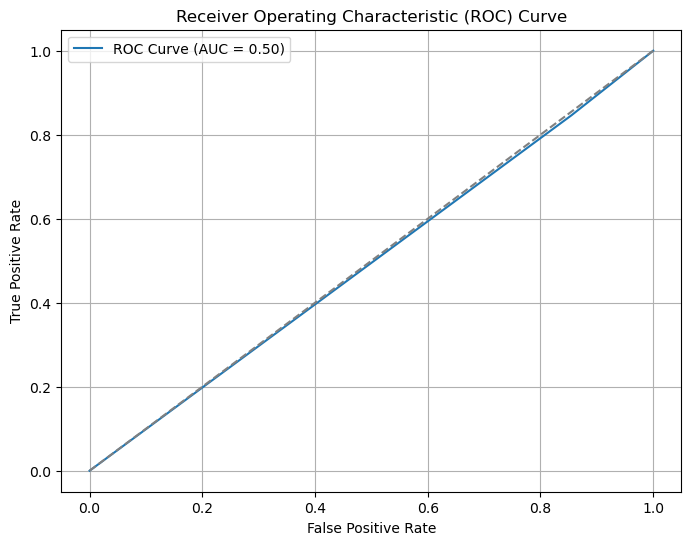

0.4956575682382134

In [91]:
from src.utils import compute_auc_roc

# d = df_xg[['outperformed', 'increased_playing_time', 'trending_upwards']]
d = df_xg[["outperformed", "increased_playing_time"]]
d = d.assign(
    outperformed=np.where(d["outperformed"], 1, 0),
    playing_time=np.where(d["increased_playing_time"] > 0, 1, 0),
    # trending_upwards = np.where(d['trending_upwards'] > 0.7, 1, 0)
)

# compute_auc_roc(d['outperformed'], d['trending_upwards'])
compute_auc_roc(d["outperformed"], d["playing_time"])

## Evaluate Model Quality

In [203]:
# df_xg['really_good'] = df_xg['fantasyPoints'] + np.random.normal(loc=0, scale=5, size=len(df_xg))

In [122]:
df = cont.get_all_episodes()
df = df[df.file_name.str.contains("week_15")]
df

,publication_date,file_name,file_path,content,duration,podcast_name
56,2024-01-26,fantasy_basketball_waiver_wire_for_week_15_202324,G:\My Drive\Columbia\Practical Deep Learning\F...,Welcome everybody to the award winning rotor w...,2839,rotowire


0it [00:00, ?it/s]

Loading from disk
Loading from disk


1it [00:49, 49.47s/it]


rows: 254
count    254.000000
mean       0.380906
std        0.419415
min       -1.000000
25%        0.300000
50%        0.500000
75%        0.600000
max        0.900000
Name: increased_playing_time, dtype: float64
AUC: 0.4956575682382134


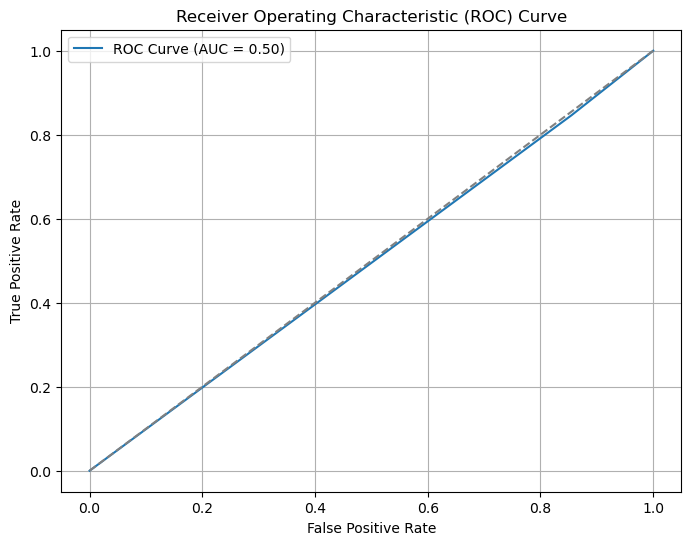

0.4956575682382134

In [119]:
## Single episode
from sklearn.model_selection import train_test_split
from src.model_xg import add_lagged_features
from xgboost import XGBRegressor

# Extract features
feats = faiss_fe.extract_llm_feats(df)

lag_features = [
    "minutes",
    "fieldGoalsAttempted",
    "fieldGoalsPercentage",
    "threePointersAttempted",
    "threePointersPercentage",
    "freeThrowsAttempted",
    "freeThrowsPercentage",
    "reboundsDefensive",
    "reboundsTotal",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "foulsPersonal",
    "points",
]

df_xg, new_feats = add_lagged_features(scores, lag_features, 5)
df_xg = df_xg.dropna()

# Merge with LLM features
df_xg = pd.merge_asof(
    df_xg,
    feats,
    left_on="game_date",
    right_on="podcast_date",
    by="personName",
    tolerance=pd.Timedelta("5d"),
)
df_xg = df_xg.dropna()

print(f"rows: {len(df_xg)}")
print(df_xg["increased_playing_time"].describe())


# ---- Plot AUC of the feature only ---
from src.utils import compute_auc_roc
d = df_xg[["outperformed", "increased_playing_time"]]
d = d.assign(
    outperformed=np.where(d["outperformed"], 1, 0),
    playing_time=np.where(d["increased_playing_time"] > 0, 1, 0),

)
compute_auc_roc(d["outperformed"], d["playing_time"])

#### LLM Features

,season_year,game_date,gameId,matchup,teamName,teamSlug,personId,personName,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed,minutes_lag_1,minutes_lag_2,minutes_lag_3,minutes_lag_4,minutes_lag_5,fieldGoalsAttempted_lag_1,fieldGoalsAttempted_lag_2,fieldGoalsAttempted_lag_3,fieldGoalsAttempted_lag_4,fieldGoalsAttempted_lag_5,fieldGoalsPercentage_lag_1,fieldGoalsPercentage_lag_2,fieldGoalsPercentage_lag_3,fieldGoalsPercentage_lag_4,fieldGoalsPercentage_lag_5,threePointersAttempted_lag_1,threePointersAttempted_lag_2,threePointersAttempted_lag_3,threePointersAttempted_lag_4,...,freeThrowsAttempted_lag_4,freeThrowsAttempted_lag_5,freeThrowsPercentage_lag_1,freeThrowsPercentage_lag_2,freeThrowsPercentage_lag_3,freeThrowsPercentage_lag_4,freeThrowsPercentage_lag_5,reboundsDefensive_lag_1,reboundsDefensive_lag_2,reboundsDefensive_lag_3,reboundsDefensive_lag_4,reboundsDefensive_lag_5,reboundsTotal_lag_1,reboundsTotal_lag_2,reboundsTotal_lag_3,reboundsTotal_lag_4,reboundsTotal_lag_5,assists_lag_1,assists_lag_2,assists_lag_3,assists_lag_4,assists_lag_5,steals_lag_1,steals_lag_2,steals_lag_3,steals_lag_4,steals_lag_5,blocks_lag_1,blocks_lag_2,blocks_lag_3,blocks_lag_4,blocks_lag_5,turnovers_lag_1,turnovers_lag_2,turnovers_lag_3,turnovers_lag_4,turnovers_lag_5,foulsPersonal_lag_1,foulsPersonal_lag_2,foulsPersonal_lag_3,foulsPersonal_lag_4,foulsPersonal_lag_5,points_lag_1,points_lag_2,points_lag_3,points_lag_4,points_lag_5,podcast_name,podcast_date,increased_playing_time
29256,2023-24,2023-10-27,22300077,DET @ CHA,pistons,pistons,1630595,cade cunningham,24.133333,4,13,0.308,2,5,0.400,2,2,1.000,1,1,2,6,1,0,5,6,12,7,23.00,33.70,False,35.766667,23.966667,35.633333,31.416667,31.233333,27.0,11.0,21.0,18.0,13.0,0.481,0.091,0.381,0.389,0.385,9.0,6.0,7.0,6.0,...,3.0,0.0,0.000,1.0,0.75,0.667,0.000,3.0,2.0,10.0,4.0,6.0,3.0,3.0,11.0,5.0,6.0,9.0,2.0,7.0,5.0,4.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,2.0,5.0,1.0,2.0,5.0,2.0,4.0,1.0,3.0,30.0,4.0,21.0,19.0,10.0,rotowire,2023-10-27,0.90
29258,2023-24,2023-10-27,22300077,DET @ CHA,pistons,pistons,1631105,jalen duren,34.850000,7,8,0.875,0,0,0.000,0,0,0.000,6,11,17,3,1,2,5,3,14,6,44.75,35.40,True,31.816667,34.666667,22.950000,34.900000,35.900000,11.0,5.0,6.0,11.0,8.0,0.727,0.400,0.833,0.818,0.875,0.0,0.0,0.0,0.0,...,0.0,7.0,0.333,0.0,0.00,0.000,0.857,8.0,15.0,7.0,5.0,11.0,14.0,18.0,10.0,8.0,14.0,4.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,4.0,1.0,2.0,0.0,1.0,4.0,6.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,3.0,17.0,4.0,10.0,18.0,20.0,rotowire,2023-10-27,0.80
29276,2023-24,2023-10-27,22300078,MEM vs. DEN,grizzlies,grizzlies,1630214,xavier tillman,34.050000,5,9,0.556,1,3,0.333,2,4,0.500,2,6,8,2,3,2,5,5,13,-5,33.50,19.15,True,33.700000,0.000000,17.900000,13.000000,29.983333,16.0,0.0,7.0,4.0,2.0,0.438,0.000,0.571,0.000,1.000,5.0,0.0,0.0,0.0,...,0.0,4.0,1.000,0.0,0.00,0.000,0.500,8.0,0.0,5.0,2.0,6.0,12.0,0.0,7.0,4.0,8.0,4.0,0.0,2.0,1.0,1.0,3.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,4.0,17.0,0.0,8.0,0.0,6.0,rotowire,2023-10-27,0.80
29311,2023-24,2023-10-27,22300079,ATL vs. NYK,hawks,hawks,1630552,jalen johnson,29.816667,5,8,0.625,0,2,0.000,1,3,0.333,0,9,9,2,1,1,3,2,11,-1,27.75,31.05,False,29.400000,18.500000,19.616667,23.383333,22.133333,13.0,10.0,8.0,11.0,10.0,0.692,0.600,0.375,0.636,0.700,3.0,4.0,2.0,2.0,...,4.0,2.0,0.500,0.5,0.00,0.500,0.500,7.0,3.0,5.0,8.0,3.0,7.0,3.0,5.0,8.0,4.0,2.0,3.0,4.0,2.0,2.0,2.0,1.0,3.0,0.0,3.0,1.0,3.0,2.0,0.0,1.0,0.0,0.0,2.0,2.0,4.0,1.0,2.0,4.0,1.0,2.0,21.0,15.0,6.0,16.0,16.0,rotowire,2023-10-27,0.55
29319,2023-24,2023-10-27,22300080,BOS vs. MIA,celtics,celtics,204001,kristaps porzingis,30.233333,6,12,0.500,2,6,0.333,3,4,0.750,3,6,9,1,3,1,1,6,17,-12,37.25,39.30,False

Sliding Window MAE: 9.779310344827586
Model MAE: 11.506344475769644
AUC: 0.546969696969697


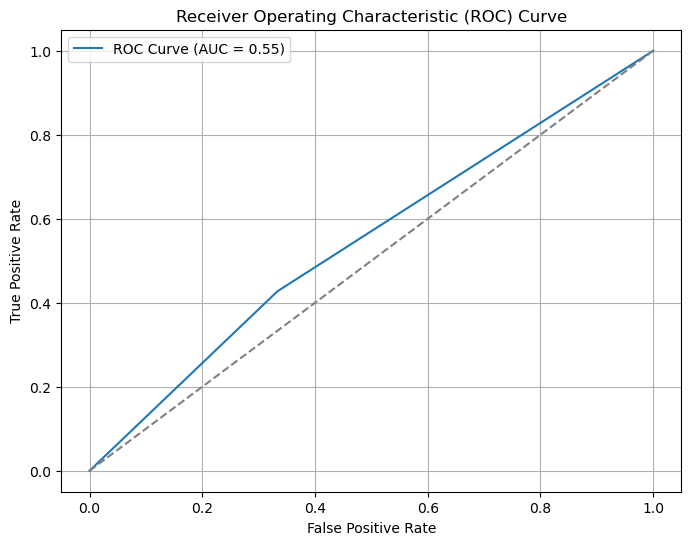

0.546969696969697

In [120]:
llm_features = ['increased_playing_time']
select_features = ["plusMinusPoints"] + llm_features + new_feats
target_col = "fantasyPoints"
y_pred = train_and_plot(df_xg, select_features, target_col)

compute_auc_roc(
    test_df["outperformed"],
    np.where(y_pred > test_df["projectedFantasyPoints"], True, False),
)

#### Baseline

,season_year,game_date,gameId,matchup,teamName,teamSlug,personId,personName,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed,minutes_lag_1,minutes_lag_2,minutes_lag_3,minutes_lag_4,minutes_lag_5,fieldGoalsAttempted_lag_1,fieldGoalsAttempted_lag_2,fieldGoalsAttempted_lag_3,fieldGoalsAttempted_lag_4,fieldGoalsAttempted_lag_5,fieldGoalsPercentage_lag_1,fieldGoalsPercentage_lag_2,fieldGoalsPercentage_lag_3,fieldGoalsPercentage_lag_4,fieldGoalsPercentage_lag_5,threePointersAttempted_lag_1,threePointersAttempted_lag_2,threePointersAttempted_lag_3,threePointersAttempted_lag_4,...,freeThrowsAttempted_lag_4,freeThrowsAttempted_lag_5,freeThrowsPercentage_lag_1,freeThrowsPercentage_lag_2,freeThrowsPercentage_lag_3,freeThrowsPercentage_lag_4,freeThrowsPercentage_lag_5,reboundsDefensive_lag_1,reboundsDefensive_lag_2,reboundsDefensive_lag_3,reboundsDefensive_lag_4,reboundsDefensive_lag_5,reboundsTotal_lag_1,reboundsTotal_lag_2,reboundsTotal_lag_3,reboundsTotal_lag_4,reboundsTotal_lag_5,assists_lag_1,assists_lag_2,assists_lag_3,assists_lag_4,assists_lag_5,steals_lag_1,steals_lag_2,steals_lag_3,steals_lag_4,steals_lag_5,blocks_lag_1,blocks_lag_2,blocks_lag_3,blocks_lag_4,blocks_lag_5,turnovers_lag_1,turnovers_lag_2,turnovers_lag_3,turnovers_lag_4,turnovers_lag_5,foulsPersonal_lag_1,foulsPersonal_lag_2,foulsPersonal_lag_3,foulsPersonal_lag_4,foulsPersonal_lag_5,points_lag_1,points_lag_2,points_lag_3,points_lag_4,points_lag_5,podcast_name,podcast_date,increased_playing_time
29256,2023-24,2023-10-27,22300077,DET @ CHA,pistons,pistons,1630595,cade cunningham,24.133333,4,13,0.308,2,5,0.400,2,2,1.000,1,1,2,6,1,0,5,6,12,7,23.00,33.70,False,35.766667,23.966667,35.633333,31.416667,31.233333,27.0,11.0,21.0,18.0,13.0,0.481,0.091,0.381,0.389,0.385,9.0,6.0,7.0,6.0,...,3.0,0.0,0.000,1.0,0.75,0.667,0.000,3.0,2.0,10.0,4.0,6.0,3.0,3.0,11.0,5.0,6.0,9.0,2.0,7.0,5.0,4.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,2.0,5.0,1.0,2.0,5.0,2.0,4.0,1.0,3.0,30.0,4.0,21.0,19.0,10.0,rotowire,2023-10-27,0.90
29258,2023-24,2023-10-27,22300077,DET @ CHA,pistons,pistons,1631105,jalen duren,34.850000,7,8,0.875,0,0,0.000,0,0,0.000,6,11,17,3,1,2,5,3,14,6,44.75,35.40,True,31.816667,34.666667,22.950000,34.900000,35.900000,11.0,5.0,6.0,11.0,8.0,0.727,0.400,0.833,0.818,0.875,0.0,0.0,0.0,0.0,...,0.0,7.0,0.333,0.0,0.00,0.000,0.857,8.0,15.0,7.0,5.0,11.0,14.0,18.0,10.0,8.0,14.0,4.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,4.0,1.0,2.0,0.0,1.0,4.0,6.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,3.0,17.0,4.0,10.0,18.0,20.0,rotowire,2023-10-27,0.80
29276,2023-24,2023-10-27,22300078,MEM vs. DEN,grizzlies,grizzlies,1630214,xavier tillman,34.050000,5,9,0.556,1,3,0.333,2,4,0.500,2,6,8,2,3,2,5,5,13,-5,33.50,19.15,True,33.700000,0.000000,17.900000,13.000000,29.983333,16.0,0.0,7.0,4.0,2.0,0.438,0.000,0.571,0.000,1.000,5.0,0.0,0.0,0.0,...,0.0,4.0,1.000,0.0,0.00,0.000,0.500,8.0,0.0,5.0,2.0,6.0,12.0,0.0,7.0,4.0,8.0,4.0,0.0,2.0,1.0,1.0,3.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,4.0,17.0,0.0,8.0,0.0,6.0,rotowire,2023-10-27,0.80
29311,2023-24,2023-10-27,22300079,ATL vs. NYK,hawks,hawks,1630552,jalen johnson,29.816667,5,8,0.625,0,2,0.000,1,3,0.333,0,9,9,2,1,1,3,2,11,-1,27.75,31.05,False,29.400000,18.500000,19.616667,23.383333,22.133333,13.0,10.0,8.0,11.0,10.0,0.692,0.600,0.375,0.636,0.700,3.0,4.0,2.0,2.0,...,4.0,2.0,0.500,0.5,0.00,0.500,0.500,7.0,3.0,5.0,8.0,3.0,7.0,3.0,5.0,8.0,4.0,2.0,3.0,4.0,2.0,2.0,2.0,1.0,3.0,0.0,3.0,1.0,3.0,2.0,0.0,1.0,0.0,0.0,2.0,2.0,4.0,1.0,2.0,4.0,1.0,2.0,21.0,15.0,6.0,16.0,16.0,rotowire,2023-10-27,0.55
29319,2023-24,2023-10-27,22300080,BOS vs. MIA,celtics,celtics,204001,kristaps porzingis,30.233333,6,12,0.500,2,6,0.333,3,4,0.750,3,6,9,1,3,1,1,6,17,-12,37.25,39.30,False

Sliding Window MAE: 9.779310344827586
Model MAE: 11.58518012286407
AUC: 0.55772238514174


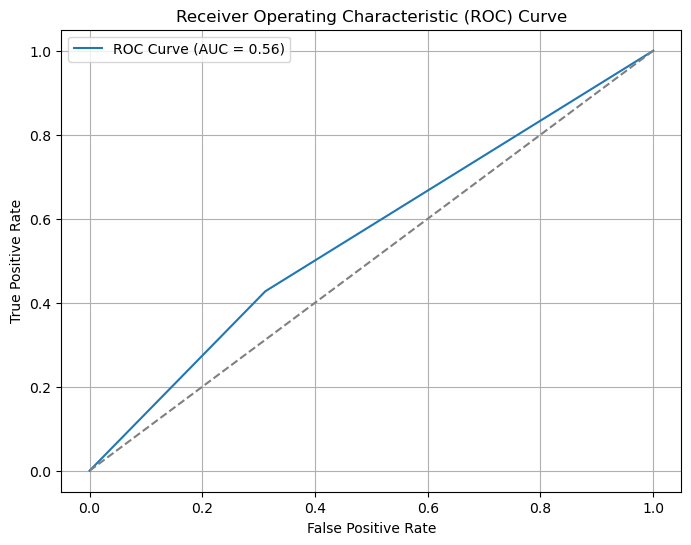

0.55772238514174

In [121]:
select_features = ["plusMinusPoints"] + new_feats
target_col = "fantasyPoints"
y_pred = train_and_plot(df_xg, select_features, target_col)

compute_auc_roc(
    test_df["outperformed"],
    np.where(y_pred > test_df["projectedFantasyPoints"], True, False),
)

In [94]:
feature_importances = model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances}
).sort_values(by="Importance", ascending=False)
importance_df

,Feature,Importance
72,points_lag_1,1.797014e-01
33,freeThrowsPercentage_lag_2,1.313717e-01
59,blocks_lag_3,9.466466e-02
49,assists_lag_3,6.276996e-02
39,reboundsDefensive_lag_3,5.515286e-02
62,turnovers_lag_1,5.139817e-02
42,reboundsTotal_lag_1,5.003651e-02
18,threePointersAttempted_lag_2,4.270764e-02
66,turnovers_lag_5,2.684875e-02
31,freeThrowsAttempted_lag_5,2.627839e-02


In [ ]:
----

In [86]:
from typing import List

from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel

system_prompt = """You are a specialized NBA analyst. Analyze the following text for NBA player mentions, including pronouns and nicknames. Provide a precise, structured analysis.

Requirements:
1. Identify all NBA players active in the 2023 season mentioned. 
2. Do not use player nicknames in the output, use their real names instead.
3. Count total mentions for each player
4. Analyze whether a player is likely to see increased playing time in upcoming games
5. Analyze whether a player is likely to outperform or trending upwards in upcoming games


Return the results as a CSV with the header:
player, mentions, increased_playing_time, trending_upwards

Context:
{}
"""

llm = ChatOpenAI(temperature=0)

response = llm.invoke(system_prompt.format(podcast_text))

In [141]:
from io import StringIO

import pandas as pd
from src.player_utils import normalize_name

df = pd.read_csv(StringIO(response.content))

df["player"] = df["player"].apply(normalize_name)
df["increased_playing_time"] = np.where(
    df["increased_playing_time"].str.lower() == "yes", 1, 0
)
df["trending_upwards"] = np.where(df["trending_upwards"].str.lower() == "yes", 1, 0)
df["podcast_date"] = pd.to_datetime(pd.to_datetime(pub_date).date())

df.head(20)

,player,mentions,increased_playing_time,trending_upwards,podcast_date
0,damian lillard,3,0,1,2023-10-27
1,tyrese maxey,1,1,1,2023-10-27
2,kelly oubre,1,0,0,2023-10-27
3,james harden,6,0,0,2023-10-27
4,joel embiid,4,0,0,2023-10-27
5,anthony davis,3,1,1,2023-10-27
6,miles turner,2,1,1,2023-10-27
7,brandon miller,1,0,0,2023-10-27
8,xavier tillman,3,1,1,2023-10-27
9,santi aldama,1,0,0,2023-10-27


In [95]:
scores.game_date.unique()

<DatetimeArray>
['2023-10-24 00:00:00', '2023-10-25 00:00:00', '2023-10-26 00:00:00',
 '2023-10-27 00:00:00', '2023-10-28 00:00:00', '2023-10-29 00:00:00',
 '2023-10-30 00:00:00', '2023-10-31 00:00:00', '2023-11-01 00:00:00',
 '2023-11-02 00:00:00',
 ...
 '2024-04-03 00:00:00', '2024-04-04 00:00:00', '2024-04-05 00:00:00',
 '2024-04-06 00:00:00', '2024-04-07 00:00:00', '2024-04-09 00:00:00',
 '2024-04-10 00:00:00', '2024-04-11 00:00:00', '2024-04-12 00:00:00',
 '2024-04-14 00:00:00']
Length: 160, dtype: datetime64[ns]

In [109]:
pub_date

datetime.date(2023, 10, 27)

In [143]:
s = scores[(scores.game_date >= "2023-10-27") & (scores.game_date <= "2023-10-31")]

# set(s.personName) & set(df.player.str.lower())
s.game_date

392548   2023-10-27
392549   2023-10-27
392550   2023-10-27
392551   2023-10-27
392552   2023-10-27
            ...    
393603   2023-10-31
393604   2023-10-31
393605   2023-10-31
393606   2023-10-31
393607   2023-10-31
Name: game_date, Length: 1060, dtype: datetime64[ns]

In [142]:
df.podcast_date

0     2023-10-27
1     2023-10-27
2     2023-10-27
3     2023-10-27
4     2023-10-27
         ...    
168   2023-10-27
169   2023-10-27
170   2023-10-27
171   2023-10-27
172   2023-10-27
Name: podcast_date, Length: 173, dtype: datetime64[ns]

In [146]:
m = pd.merge_asof(
    s,
    df,
    left_on="game_date",
    right_on="podcast_date",
    left_by="personName",
    right_by="player",
    tolerance=pd.Timedelta("5d"),
)
m

,season_year,game_date,gameId,matchup,teamName,teamSlug,personId,personName,minutes,fieldGoalsMade,...,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed,player,mentions,increased_playing_time,trending_upwards,podcast_date
0,2023-24,2023-10-27,22300077,CHA vs. DET,hornets,hornets,202330,gordon hayward,33.866667,6,...,19,-10,40.75,33.550000,True,NaN,NaN,NaN,NaN,NaT
1,2023-24,2023-10-27,22300077,DET @ CHA,pistons,pistons,202692,alec burks,30.750000,5,...,24,28,36.00,20.650000,True,NaN,NaN,NaN,NaN,NaT
2,2023-24,2023-10-27,22300077,DET @ CHA,pistons,pistons,203925,joe harris,11.316667,1,...,2,3,5.50,7.950000,False,NaN,NaN,NaN,NaN,NaT
3,2023-24,2023-10-27,22300077,CHA vs. DET,hornets,hornets,1626179,terry rozier,34.700000,8,...,20,-11,26.25,24.200000,True,NaN,NaN,NaN,NaN,NaT
4,2023-24,2023-10-27,22300077,CHA vs. DET,hornets,hornets,1628373,frank ntilikina,0.000000,0,...,0,0,0.00,11.100000,False,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055,2023-24,2023-10-31,22300114,LAC vs. ORL,clippers,clippers,1631217,moussa diabate,2.916667,1,...,2,2,5.75,2.850000,True,NaN,NaN,NaN,NaN,NaT
1056,2023-24,2023-10-31,22300114,ORL @ LAC,magic,magic,1641710,anthony black,3.933333,0,...,0,-1,1.50,3.500000,False,NaN,NaN,NaN,NaN,NaT
1057,2023-24,2023-10-31,22300114,ORL @ LAC,magic,magic,1641724,jett howard,3.933333,1,...,2,-1,3.25,0.500000,True,NaN,NaN,NaN,NaN,NaT
1058,2023-24,2023-10-31,22300114,LAC vs. ORL,clippers,clippers,1641738,kobe brown,19.033333,3,...,7,11,14.25,3.833333,True,NaN,NaN,NaN,NaN,NaT


In [149]:
m[m.game_date == "2023-10-27"].head(40)

,season_year,game_date,gameId,matchup,teamName,teamSlug,personId,personName,minutes,fieldGoalsMade,...,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed,player,mentions,increased_playing_time,trending_upwards,podcast_date
0,2023-24,2023-10-27,22300077,CHA vs. DET,hornets,hornets,202330,gordon hayward,33.866667,6,...,19,-10,40.75,33.55,True,NaN,NaN,NaN,NaN,NaT
1,2023-24,2023-10-27,22300077,DET @ CHA,pistons,pistons,202692,alec burks,30.750000,5,...,24,28,36.00,20.65,True,NaN,NaN,NaN,NaN,NaT
2,2023-24,2023-10-27,22300077,DET @ CHA,pistons,pistons,203925,joe harris,11.316667,1,...,2,3,5.50,7.95,False,NaN,NaN,NaN,NaN,NaT
3,2023-24,2023-10-27,22300077,CHA vs. DET,hornets,hornets,1626179,terry rozier,34.700000,8,...,20,-11,26.25,24.20,True,NaN,NaN,NaN,NaN,NaT
4,2023-24,2023-10-27,22300077,CHA vs. DET,hornets,hornets,1628373,frank ntilikina,0.000000,0,...,0,0,0.00,11.10,False,NaN,NaN,NaN,NaN,NaT
5,2023-24,2023-10-27,22300077,DET @ CHA,pistons,pistons,1628963,marvin bagley iii,13.150000,5,...,14,6,20.50,13.70,True,NaN,NaN,NaN,NaN,NaT
6,2023-24,2023-10-27,22300077,CHA vs. DET,hornets,hornets,1628970,miles bridges,0.000000,0,...,0,0,0.00,30.55,False,NaN,NaN,NaN,NaN,NaT
7,2023-24,2023-10-27,22300077,CHA vs. DET,hornets,hornets,1629023,pj washington,28.983333,6,...,13,-12,26.25,39.55,False,NaN,NaN,NaN,NaN,NaT
8,2023-24,2023-10-27,22300077,CHA vs. DET,hornets,hornets,1630163,lamelo ball,33.066667,4,...,20,-7,48.75,47.65,True,NaN,NaN,NaN,NaN,NaT
9,2023-24,2023-10-27,22300077,DET @ CHA,pistons,pistons,1630164,james wiseman,0.000000,0,...,0,0,0.00,16.30,False,NaN,NaN,NaN,NaN,NaT


In [147]:
m[~m.player.isnull()]

,season_year,game_date,gameId,matchup,teamName,teamSlug,personId,personName,minutes,fieldGoalsMade,...,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed,player,mentions,increased_playing_time,trending_upwards,podcast_date
15,2023-24,2023-10-27,22300077,DET @ CHA,pistons,pistons,1630595,cade cunningham,24.133333,4,...,12,7,23.00,33.700000,False,cade cunningham,2.0,1.0,1.0,2023-10-27
24,2023-24,2023-10-27,22300077,CHA vs. DET,hornets,hornets,1641706,brandon miller,33.416667,6,...,17,-2,30.00,19.250000,True,brandon miller,1.0,0.0,0.0,2023-10-27
44,2023-24,2023-10-27,22300078,MEM vs. DEN,grizzlies,grizzlies,1630214,xavier tillman,34.050000,5,...,13,-5,33.50,19.150000,True,xavier tillman,3.0,1.0,1.0,2023-10-27
131,2023-24,2023-10-27,22300081,OKC @ CLE,thunder,thunder,1630198,isaiah joe,22.300000,2,...,5,12,11.25,16.000000,False,isaiah joe,2.0,1.0,1.0,2023-10-27
140,2023-24,2023-10-27,22300081,OKC @ CLE,thunder,thunder,1631096,chet holmgren,30.850000,5,...,16,6,52.25,22.000000,True,chet holmgren,4.0,0.0,0.0,2023-10-27
150,2023-24,2023-10-27,22300082,CHI vs. TOR,bulls,bulls,203083,andre drummond,12.333333,3,...,8,1,9.50,10.750000,False,andre drummond,2.0,1.0,1.0,2023-10-27
224,2023-24,2023-10-27,22300084,BKN @ DAL,nets,nets,1630560,cam thomas,33.166667,12,...,30,3,45.75,19.150000,True,cam thomas,4.0,1.0,1.0,2023-10-27
288,2023-24,2023-10-27,22300087,GSW @ SAC,warriors,warriors,101108,chris paul,33.166667,5,...,10,2,36.50,34.250000,True,chris paul,2.0,1.0,1.0,2023-10-27
318,2023-24,2023-10-28,22300088,CHI @ DET,bulls,bulls,203083,andre drummond,14.466667,1,...,2,-5,19.25,10.450000,True,andre drummond,2.0,1.0,1.0,2023-10-27
331,2023-24,2023-10-28,22300088,DET vs. CHI,pistons,pistons,1630595,cade cunningham,39.616667,9,...,25,10,43.50,33.400000,True,cade cunningham,2.0,1.0,1.0,2023-10-27


{'andre drummond',
 'brandon miller',
 'cade cunningham',
 'cam thomas',
 'chet holmgren',
 'chris paul',
 'isaiah joe',
 'xavier tillman'}

,player,mentions,increased_playing_time,trending_upwards
0,Damian Lillard,3.0,no,yes
1,Tyrese Maxey,1.0,yes,yes
2,Kelly Oubre,1.0,no,no
3,James Harden,6.0,no,no
4,Joel Embiid,3.0,no,no
5,Terrence Mann,1.0,no,no
6,Norm Powell,1.0,no,no
7,Bones Hyland,1.0,no,no
8,Anthony Davis,1.0,no,no
9,Miles Turner,2.0,no,no


In [73]:
import spacy

# Load SpaCy English model
nlp = spacy.load("en_core_web_lg")

# Process the text with SpaCy
doc = nlp(podcast_text)

target = "James Harden"
# Count mentions of "James Harden"
count = sum(1 for ent in doc.ents if ent.text == target and ent.label_ == "PERSON")
count

2

In [ ]:
-----

In [ ]:
prompt = podcast_text

messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": prompt},
]

from langchain_google_vertexai import ChatVertexAI

llm = ChatVertexAI(model="gemini-1.5-flash", temperature=0)
response = llm.invoke(messages)

print("Response:", response.content)

In [19]:
response.content

"```csv\nPlayer,Mentions,Increased Playing Time,Trending Upwards\nDamian Lillard,4,No,No\nJames Harden,6,No,No\nTyrese Maxey,1,Yes,Yes\nKelly Oubre,1,No,No\nJoel Embiid,2,No,No\nTerrence Mann,1,No,No\nNorm Powell,1,No,No\nBones Hyland,1,No,No\nBogdanovic,1,No,No\nAnthony Davis,2,No,No\nLeBron James,1,No,No\nKevin Durant,2,No,No\nYousef Nurkic,1,No,No\nEric Gordon,3,Yes,No\nJordan Goodwin,1,Yes,Yes\nJay Eric Gordon,1,No,No\nBradley Beal,3,No,No\nMiles Turner,2,No,No\nBrandon Miller,2,No,No\nXavier Tillman,3,Yes,Yes\nSanti Aldama,2,Yes,Yes\nJaren Jackson,1,No,No\nJa Morant,1,No,No\nKobe White,3,Yes,Yes\nDerek Lively,4,Yes,Yes\nMaxi Kleber,1,No,No\nKyrie Irving,1,No,No\nJason Kidd,1,No,No\nJalen Johnson,4,Yes,Yes\nSadik Bey,3,No,No\nDeandre Hunter,2,No,No\nDonovic Mitchell,1,No,No\nAJ Griffin,2,No,No\nCam Thomas,6,Yes,Yes\nRoyce O'Neil,1,No,No\nDorian Finney Smith,1,No,No\nBen Simmons,2,No,No\nNick Claxton,2,No,No\nCam Johnson,2,No,No\nSpencer Dinwiddie,1,No,No\nMax Struss,5,Yes,Yes\nJare

In [4]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

prompt = "What is the capital of France?"

messages = [
    {
        "role": "system",
        "content": "You are a helpful assistant that answers questions.",
    },
    {"role": "user", "content": prompt},
]
response = llm.invoke(prompt)
response.content

'The capital of France is Paris.'

In [3]:
# import vertexai
# vertexai.init()


from langchain_google_vertexai import ChatVertexAI

llm = ChatVertexAI(model="gemini-1.5-flash", temperature=0)


prompt = "What is the capital of France?"

messages = [
    {
        "role": "system",
        "content": "You are a helpful assistant that answers questions.",
    },
    {"role": "user", "content": prompt},
]


response = llm.invoke(messages)


print("Response:", response.content)

Response: The capital of France is **Paris**. 

